<a href="https://colab.research.google.com/github/SimoneCallegarin/NLP_project/blob/main/SA%20and%20TextGen%20on%20EDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

## **Libraries Imports**

In [ ]:
import pandas as pd
import re
from collections import Counter
#from google.colab import files

In [ ]:
# Downsampling:
!pip install --quiet --root-user-action=ignore hyperopt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint
from xgboost import XGBClassifier
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
# Preprocessing:
!pip install --quiet --root-user-action=ignore pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import regexp_replace, lower, trim, size, col, array_except, array, lit, udf, row_number
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline

In [ ]:
# Interactive table library:
!pip install --quiet --root-user-action=ignore ipyaggrid
import ipyaggrid
from IPython.display import display
from ipywidgets import widgets
# Enable the custom widget manager
display(widgets.Output())

Output()

In [ ]:
# Clustering:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from pyspark.ml.clustering import LDA
#from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import regexp_replace, split
from numpy import float32,argmax

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install --quiet --root-user-action=ignore tensorflow_addons 
from tensorflow.data import Dataset,experimental
from tensorflow.keras.layers import Input,Dense,LSTM,TextVectorization,Reshape,Flatten,Embedding,Dropout,Bidirectional
from tensorflow.keras.models import Sequential,Model
from tensorflow import expand_dims,string,strings
from tensorflow.keras.metrics import Accuracy
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow import initializers,convert_to_tensor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [ ]:
#HF Transformers
from transformers import RobertaTokenizerFast,AutoModelForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding,AlbertTokenizerFast
from datasets import load_dataset,Dataset

In [ ]:
# Graphs:
%%capture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 5))

A function for printing graphs in a formatted way

In [ ]:
def print_graph(title, xlab, ylab, rotated):
    plt.title(title)
    plt.ylabel(ylab, fontsize=12)
    plt.xlabel(xlab, fontsize=12)
    if rotated:
        plt.xticks(rotation=90)

## **Dataset Download**

Loading the paths of the data that will be used.

In [ ]:
csv_path_initial = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/Data/EDOS_1M.csv"
csv_path_preprocessed_texts = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/Data/preprocessed_texts.csv"
csv_path_preprocessed_tokens = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/Data/preprocessed_tokens.csv"

# **Dataset Import and Cleaning**

We will now import the EDOS dataset and clean it from:
    
- duplicates
- null values

In [ ]:
df = pd.read_csv(csv_path_initial)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


In [ ]:
df.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


In [ ]:
df.duplicated().sum()

0

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return None
    else:
        return s

In [ ]:
df['uttr'].apply(lambda s: isEnglish(s)).size  #same size as before, no rows were removed 

2829426

As we can see the dataset was already cleaned since we have no duplicated, null rows or not-ASCII characters (which usually means we are dealing with a multilingual dataset), so we can proceed to the next steps without worries.

--- 
Here instead we load two already preprocessed version of the dataset (in the **Dataset Preprocessing** section), one with only text preprocessing and the other a full tokenization and preprocessing. Data is made available in the [github repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data).

In [ ]:
texts_df = pd.read_csv(csv_path_preprocessed_texts)
tokens_df = pd.read_csv(csv_path_preprocessed_tokens)

# **Preliminary Analysis**

## **EDA - Exploratory Data Analysis**

Before diving into the training and evaluation of many different NLP models, we will perform the EDA (Exploratory Data Analysis) to have basic but fundamental insights about the data.

In particular we will get:

- basic informations about the dataset
- some descriptive statistics

### **Basic Understanding of the Dataset**

As stated on the dataset website, EDOS contains short phrases (from 3 to 5 utterances), each labeled with an emotion. Let's get a better look at them

In [ ]:
print([x for x in df['uttr'][0:5]])

['You moron ! What fool washes diapers by the well !', 'You useless fool !', 'How dare you sleep !', 'Up ! Go and clean the house .', 'Clean the kitchen .']


Let's now check all the possible values of the emotion type, which will be our target in case of sentiment analysis

In [ ]:
emotions = df['eb+_emot'].unique()
print(emotions)

['angry' 'furious' 'prepared' 'acknowledging' 'trusting' 'confident'
 'hopeful' 'caring' 'sentimental' 'anticipating' 'wishing' 'surprised'
 'ashamed' 'questioning' 'sad' 'nostalgic' 'devastated' 'terrified'
 'embarrassed' 'lonely' 'encouraging' 'suggesting' 'content' 'afraid'
 'impressed' 'agreeing' 'apprehensive' 'proud' 'annoyed' 'anxious'
 'grateful' 'excited' 'neutral' 'faithful' 'guilty' 'consoling'
 'disgusted' 'disappointed' 'jealous' 'joyful' 'sympathizing']


With all these possible emotions to predict, it's very probable that we will have to deal with unbalanced classes

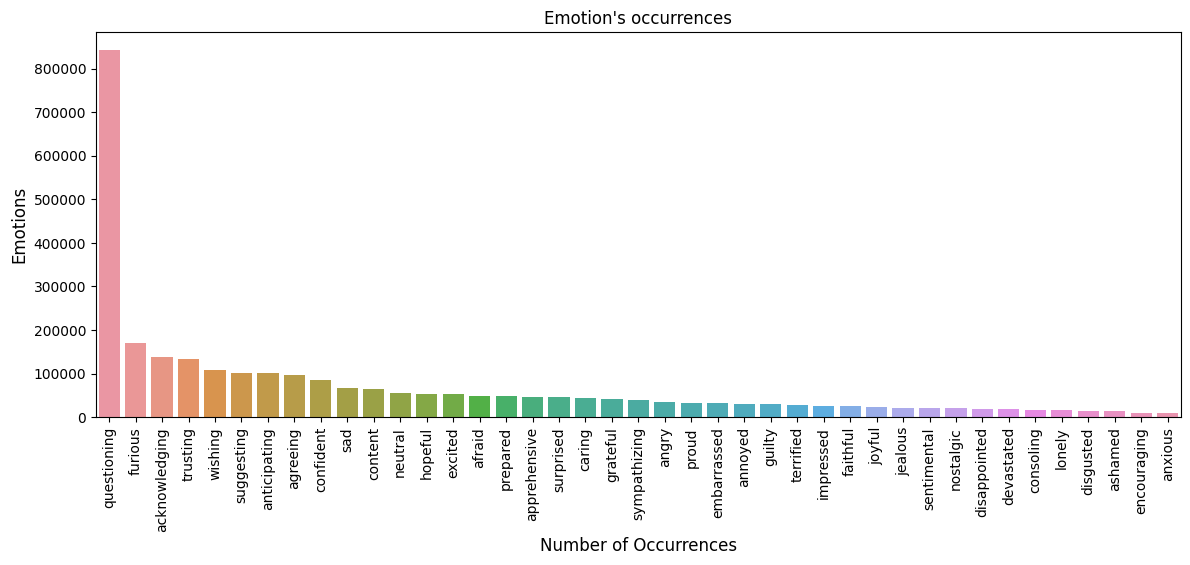

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(data=df, x='eb+_emot', order=df['eb+_emot'].value_counts().index, ax=ax)
print_graph('Emotion\'s occurrences', 'Number of Occurrences', 'Emotions', True)

In [ ]:
df['eb+_emot'].value_counts()[:5]

questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
Name: eb+_emot, dtype: int64

As we can see, we have quite an unbalancing here with the 'questioning' texts being over 800k while all the others stay under 200k.

We will have to deal with it in the next phases when we will have to train models on this dataset

### **Descriptive Statistics**

We will use some text visualization techniques for better and instant insights about:

- text lengths distribution
- word number distribution

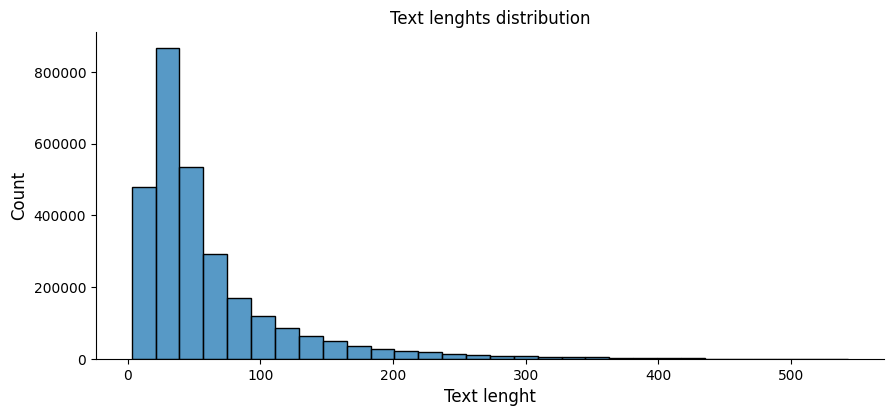

In [ ]:
sns.displot(df['uttr'].str.len(), kde = False, bins = 30, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

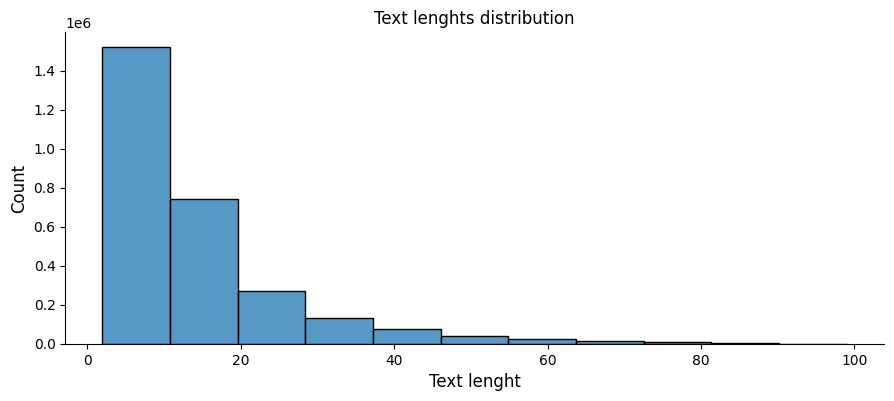

In [ ]:
sns.displot(df['uttr'].str.split().map(lambda x: len(x)), kde = False, bins = 11, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

It's clear that most texts' vocabulary size stays under 20 words, with the most being between 2 and 10.

But we can also see we have pretty long texts too so let's have a look at one of them

In [ ]:
df[(df['uttr'].str.len() > 300)]['uttr'].iloc[0]

"Glenn , why don 't you tell us about the top looks ? Kris , we love the ram look of your makeup , and some of the smaller sculptural details were very impressive . It was a very comprehensive makeup . Wayne , your use of proportion was excellent this week . We were also blown away by how much killer sculpting you pulled off . Who is the winner of this challenge ?"

## **Dataset Preprocessing**

### **Downsampling**

We have to decide how much data to have for each class. Since we don't want to have repeating data points, we will keep the number of samples corresponding to the ones we have in the least populated class. So the number of discarded points of a certain class will be proportional to the original size of that class.

In [ ]:
ds = df[['eb+_emot','uttr']]

In [ ]:
n_samples = ds['eb+_emot'].value_counts()[-1]
print("Number of samples:",n_samples)
n_classes = ds['eb+_emot'].unique().size
print("Number of classes:",n_classes)

Number of samples: 8578
Number of classes: 41


In [ ]:
downsample_ds = pd.DataFrame(columns=ds.columns)
for label in ds['eb+_emot'].unique():
    partial_ds = resample(ds[ds['eb+_emot']==label],random_state=42,replace=True,n_samples=n_samples)
    downsample_ds = pd.concat([downsample_ds,partial_ds])

In [ ]:
downsample_ds['eb+_emot'].value_counts()

angry            8578
suggesting       8578
afraid           8578
impressed        8578
agreeing         8578
apprehensive     8578
proud            8578
annoyed          8578
anxious          8578
grateful         8578
excited          8578
neutral          8578
faithful         8578
guilty           8578
consoling        8578
disgusted        8578
disappointed     8578
jealous          8578
joyful           8578
content          8578
encouraging      8578
furious          8578
lonely           8578
prepared         8578
acknowledging    8578
trusting         8578
confident        8578
hopeful          8578
caring           8578
sentimental      8578
anticipating     8578
wishing          8578
surprised        8578
ashamed          8578
questioning      8578
sad              8578
nostalgic        8578
devastated       8578
terrified        8578
embarrassed      8578
sympathizing     8578
Name: eb+_emot, dtype: int64

### **Spark Preprocessing**

We used *pyspark* to scale the workload to any size by running it distributed across multiple nodes.

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName('Preprocess').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/05 12:27:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/05 12:27:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(downsample_ds)

# Show the first few rows of the Spark DataFrame
df_spark.show(truncate=False)

23/05/05 12:28:03 WARN TaskSetManager: Stage 0 contains a task of very large size (4430 KiB). The maximum recommended task size is 1000 KiB.


+--------+-----------------------------------------------------------------------------------------------------------------------------------------+
|eb+_emot|uttr                                                                                                                                     |
+--------+-----------------------------------------------------------------------------------------------------------------------------------------+
|angry   |It 's fired up by powerful negative emotions , like fear , rage , anger , and hate .                                                     |
|angry   |Hell no !                                                                                                                                |
|angry   |Yuki Yuki won 't get up Yuki !                                                                                                           |
|angry   |Jesus Christ , they 're shooting at us !                                                        

In [ ]:
# Define a function to expand contractions
def expand_contractions(text):
    contractions = {
        "ain 't": "am not", "aren 't": "are not", "can 't": "cannot", "can 't 've": "cannot have", "'cause": "because", "could 've": "could have", "couldn 't": "could not", "couldn 't 've": "could not have", "didn 't": "did not", "doesn 't": "does not", "don 't": "do not", "hadn 't": "had not", "hadn 't've": "had not have", "hasn 't": "has not", "haven 't": "have not", "he 'd": "he would", "he 'd 've": "he would have", "he 'll": "he will", "he 'll 've": "he will have", "he 's": "he is", "how 'd": "how did", "how 'd 'y": "how do you", "how 'll": "how will", "how 's": "how is", "i 'd": "i would", "i 'd've": "i would have", "i 'll": "i will", "i 'll've": "i will have", "i 'm": "i am", "i 've": "i have", "isn 't": "is not", "it 'd": "it would", "it 'd've": "it would have", "it 'll": "it will", "it 'll've": "it will have", "it 's": "it is", "let 's": "let us", "ma 'am": "madam", "mayn 't": "may not", "might 've": "might have", "mightn 't": "might not", "mightn 't 've": "might not have", "must 've": "must have", "mustn 't": "must not", "mustn 't 've": "must not have", "needn 't": "need not", "needn 't 've": "need not have", "o 'clock": "of the clock", "oughtn 't": "ought not", "oughtn 't 've": "ought not have", "shan 't": "shall not", "sha 'n 't": "shall not", "shan 't 've": "shall not have", "she 'd": "she would", "she 'd 've": "she would have", "she 'll": "she will", "she 'll 've": "she will have", "she 's": "she is", "should 've": "should have", "shouldn 't": "should not", "shouldn 't 've": "should not have", "so 've": "so have", "so 's": "so is", "that 'd": "that would", "that 'd 've": "that would have", "that 's": "that is", "there 'd": "there would", "there 'd've": "there would have", "there 's": "there is", "they 'd": "they would", "they 'd 've": "they would have", "they 'll": "they will", "they 'll 've": "they will have", "they 're": "they are", "they 've": "they have", "to 've": "to have", "wasn 't": "was not", "we 'd": "we would", "we 'd 've": "we would have", "we 'll": "we will", "we 'll 've": "we will have", "we 're": "we are", "we 've": "we have", "weren 't": "were not", "what 'll": "what will", "what 'll 've": "what will have", "what 're": "what are", "what 's": "what is", "what 've": "what have", "when 's": "when is", "when 've": "when have", "where 'd": "where did", "where 's": "where is", "where 've": "where have", "who 'll": "who will", "who 'll've": "who will have", "who 's": "who is", "who 've": "who have", "why 's": "why is", "why 've": "why have", "will 've": "will have", "won 't": "will not", "won 't've": "will not have", "would 've": "would have", "wouldn 't": "would not", "wouldn 't've": "would not have", "y 'all": "you all", "y 'all 'd": "you all would", "y 'all 'd've": "you all would have", "y 'all 're": "you all are", "y 'all 've": "you all have", "you 'd": "you would", "you 'd 've": "you would have", "you 'll": "you will", "you 'll 've": "you will have", "you 're": "you are", "you 've": "you have"
    }
    for contraction, replacement in contractions.items():
        text = text.replace(contraction, replacement)
    return text

Applying to the text of the dataset the following:
* Lowercase the texts of the utterances (the 'uttr' column)
* Expand contractions
* Remove punctuation
* Remove numbers
* Remove leading and trailing spaces of each sentence
* Replace all multiple spaces between each word (generated in previous steps) with a single space

In [ ]:
# Lowercase utterances words
texts_df_sp = df_spark.select('eb+_emot', lower('uttr').alias('cleaned_text'))

# Expand contractions 
texts_df_sp = texts_df_sp.withColumn('cleaned_text',udf(expand_contractions, StringType())('cleaned_text'))

# Remove punctuation and numbers 
texts_df_sp = texts_df_sp.withColumn('cleaned_text', regexp_replace('cleaned_text', '[^a-zA-Z\s]+', ''))

# Remove leading and trailing spaces
texts_df_sp = texts_df_sp.withColumn('cleaned_text', trim(texts_df_sp['cleaned_text']))

# Replace multiple spaces with single spaces
texts_df_sp = texts_df_sp.withColumn('cleaned_text', regexp_replace('cleaned_text', '\s+', ' '))

For completeness we printed some rows for each emotion of the preprocessed dataframe obtained in this stage.

In [ ]:
# define a window specification to partition the rows by eb+_emot and order them by the default order
window_spec = Window.partitionBy("eb+_emot").orderBy("cleaned_text")

# assign a row number to each row within each group of eb+_emot values
df_with_row_number = texts_df_sp.withColumn("row_number", row_number().over(window_spec))

# filter the rows with row numbers less than or equal to 2
print_df = df_with_row_number.filter("row_number <= 2")

# print the resulting DataFrame
print_df.show(truncate=False)

+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|eb+_emot    |cleaned_text                                                                                                                                                                                                                                                |row_number|
+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|afraid      |a bad idea jack s right you will just stir up a hornets nest                                                                                         

Tokenize the text that was preprocessed before, remove the stop words from the tokens, and remove rows left without token.

In [ ]:
# Tokenize text 
tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='tokens')

# Filter out stop words
stop_words = StopWordsRemover.loadDefaultStopWords('english')
stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens', stopWords=stop_words)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover])

# Execute the pipeline and select the two interesting rows
tokens_df_sp = pipeline.fit(texts_df_sp).transform(texts_df_sp).select('eb+_emot','filtered_tokens')

# Filter utterances without tokens
tokens_df_sp = tokens_df_sp.filter(size(col('filtered_tokens')) != 0)

For completeness we printed some rows for each emotion of the preprocessed dataframe obtained with the last stage.

In [ ]:
# define a window specification to partition the rows by eb+_emot and order them by the default order
window_spec = Window.partitionBy("eb+_emot").orderBy("filtered_tokens")

# assign a row number to each row within each group of eb+_emot values
df_with_row_number = tokens_df_sp.withColumn("row_number", row_number().over(window_spec))

# filter the rows with row numbers less than or equal to 2
print_df = df_with_row_number.filter("row_number <= 2")

# print the resulting DataFrame
print_df.show(truncate=False)

+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|eb+_emot    |filtered_tokens                                                                                                                                          |row_number|
+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|afraid      |[aah, latches, afraid]                                                                                                                                   |1         |
|afraid      |[abby, somebody, tried, kill, lab, safe]                                                                                                                 |2         |
|agreeing    |[aah]                                                                                 

### **Store the Preprocessed Datasets**

Convert the spark dataframes that have been preprocessed and download them.
We proceeded to upload them in the github repository.

In [ ]:
texts_df = texts_df_sp.toPandas()
tokens_df = tokens_df_sp.toPandas()

In [ ]:
texts_df.to_csv('preprocessed_texts.csv', index=False ,encoding = 'utf-8') 
files.download('preprocessed_texts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tokens_df.to_csv('preprocessed_tokens.csv', index=False ,encoding = 'utf-8') 
files.download('preprocessed_tokens.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Preprocessing Results**

These are the results of the preprocessing phase. Data is made available in the [github repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data).

In [ ]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351698 entries, 0 to 351697
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   eb+_emot      351698 non-null  object
 1   cleaned_text  351698 non-null  object
dtypes: object(2)
memory usage: 5.4+ MB


In [ ]:
tokens_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349920 entries, 0 to 349919
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   eb+_emot         349920 non-null  object
 1   filtered_tokens  349920 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


Showing the resulting dataframes:

In [ ]:
print(texts_df)

            eb+_emot                                       cleaned_text
0              angry  it is fired up by powerful negative emotions l...
1              angry                                            hell no
2              angry                     yuki yuki will not get up yuki
3              angry               jesus christ they are shooting at us
4              angry  damn it alexander shoot what the hell why will...
...              ...                                                ...
351693  sympathizing  hello oishisan it is your fault things have tu...
351694  sympathizing                                       sorry mother
351695  sympathizing                  i am really sorry do not sweat it
351696  sympathizing                        i am sorry what is going on
351697  sympathizing                                you know i am sorry

[351698 rows x 2 columns]


In [ ]:
print(tokens_df)

            eb+_emot                                    filtered_tokens
0              angry  ['fired', 'powerful', 'negative', 'emotions', ...
1              angry                                           ['hell']
2              angry                    ['yuki', 'yuki', 'get', 'yuki']
3              angry              ['jesus', 'christ', 'shooting', 'us']
4              angry     ['damn', 'alexander', 'shoot', 'hell', 'help']
...              ...                                                ...
349915  sympathizing  ['hello', 'oishisan', 'fault', 'things', 'turn...
349916  sympathizing                                ['sorry', 'mother']
349917  sympathizing                       ['really', 'sorry', 'sweat']
349918  sympathizing                                 ['sorry', 'going']
349919  sympathizing                                  ['know', 'sorry']

[349920 rows x 2 columns]


## **Clustering**

In this section we will apply some clustering techniques to check what groups can be found and if those corresponds, even partially, to our known classes.

In [ ]:
tokens_df = pd.read_csv(csv_path_preprocessed_tokens) # this is the preprocessed dataset we are using (tokenization and stop words removal)

In [ ]:
emotions = tokens_df['eb+_emot'].unique()
n_topics = len(emotions)

In [ ]:
min_doc_freq = 120
max_doc_freq = 0.7

### **Vectorization with TF-IDF**

Before diving into clustering, we will have to preprocess our dataset. In particular we will have to vectorize our texts and to do that we will use TF-IDF.

In [ ]:
X = tokens_df['filtered_tokens']
y = tokens_df['eb+_emot']

We will remove numbers since they don't represent any meaningful information in our semantical context and they only enlarge TF-IDF vectors slowing down training and preprocessing steps.

We will remove numbers and stopwords from the corpus, plus words appearing in less than 10 documents or in more than the 80% of the collection (to remove corpus-specific stopwords).

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            lowercase=True,
                            min_df=min_doc_freq,
                            max_df=max_doc_freq
                           )

In [ ]:
Xf = tfidf_vec.fit_transform(X)

In [ ]:
tfidf_vec.get_feature_names_out().size

2016

In [ ]:
print('Vocabulary: ')
print(tfidf_vec.get_feature_names_out())

Vocabulary: 
['able' 'absolutely' 'accept' ... 'young' 'younger' 'youth']


### **Clustering with K-Means**

K-Means clustering algorithm is applyed to already fully preprocessed and vectorized data. The random seed and other hyperparameters have been chosen between many possible combination in order to select the one with higher number of clusters as well defined as possible.

In [ ]:
kmeans = KMeans(n_clusters=n_topics,
                max_iter=100,
                n_init=7,
                verbose=False,
                random_state=2153)
kmeans.fit(Xf)

KMeans(max_iter=100, n_clusters=41, n_init=7, random_state=2153, verbose=False)

In [ ]:
# Predict the cluster labels for each data point
labels = kmeans.predict(Xf)

# Create a dictionary that maps each topic to its corresponding cluster label
topic_map = {}
for i, topic in enumerate(emotions):
    topic_map[topic] = labels[i]

# Create a dictionary that maps each cluster label to a list of topics
cluster_topics = {}
for topic, cluster in topic_map.items():
    if cluster not in cluster_topics:
        cluster_topics[cluster] = []
    cluster_topics[cluster].append(topic)

print("Number of clusters identified:",len(cluster_topics.items()))

print("Number of data points in each cluster:")
print(Counter(labels))

Number of clusters identified: 13
Number of data points in each cluster:
Counter({1: 212332, 32: 10789, 33: 8675, 24: 6642, 15: 6449, 17: 6404, 11: 6302, 23: 6039, 34: 5696, 36: 5687, 14: 5510, 2: 5328, 3: 5091, 8: 4849, 39: 4258, 27: 4224, 40: 4035, 21: 3802, 22: 3754, 16: 3545, 7: 3455, 37: 3304, 25: 3217, 13: 3058, 0: 2948, 5: 2100, 10: 1828, 4: 1757, 19: 1602, 35: 1448, 26: 1359, 30: 895, 6: 674, 29: 656, 28: 479, 18: 403, 20: 378, 9: 274, 31: 257, 12: 256, 38: 161})


The number of clusters identified is quite low compared to the number of topics (41 emotions) given. Clusters' data points are also quite unbalanced in distribution.

The algorithm has been able only to identify some of the original topics, while the others (29 emotions) have been all merged togheter in a big cluster:

In [ ]:
# Print the topics for each cluster label
print("Topics for each cluster label:")
for cluster, topics in cluster_topics.items():
    print("Cluster {}: {}".format(cluster, ", ".join(topics)))

Topics for each cluster label:
Cluster 32: angry
Cluster 1: furious, prepared, acknowledging, confident, caring, sentimental, wishing, surprised, ashamed, questioning, nostalgic, terrified, embarrassed, lonely, encouraging, suggesting, content, afraid, impressed, apprehensive, proud, annoyed, anxious, grateful, neutral, faithful, jealous, joyful, sympathizing
Cluster 13: trusting
Cluster 0: hopeful
Cluster 12: anticipating
Cluster 17: sad
Cluster 23: devastated
Cluster 16: agreeing
Cluster 11: excited
Cluster 31: guilty
Cluster 14: consoling
Cluster 8: disgusted
Cluster 15: disappointed


Let's have a look to the content of the clusters by showing the top terms per clusters.

In [ ]:
print("Top terms per cluster:")
vocab = tfidf_vec.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    if i in cluster_topics.keys():   
      print(f"Cluster {i} :\t{[vocab[j] for j in sorted_terms[:10]]}","->",(cluster_topics[i]))
    else:
      print(f"Cluster {i} :\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0 :	['years', 'ago', 'old', 'know', 'like', 'time', 'remember', 'life', 'long', 'seen'] -> ['hopeful']
Cluster 1 :	['good', 'want', 'think', 'yes', 'look', 'yeah', 'okay', 'tell', 'make', 'way'] -> ['furious', 'prepared', 'acknowledging', 'confident', 'caring', 'sentimental', 'wishing', 'surprised', 'ashamed', 'questioning', 'nostalgic', 'terrified', 'embarrassed', 'lonely', 'encouraging', 'suggesting', 'content', 'afraid', 'impressed', 'apprehensive', 'proud', 'annoyed', 'anxious', 'grateful', 'neutral', 'faithful', 'jealous', 'joyful', 'sympathizing']
Cluster 2 :	['really', 'know', 'sorry', 'like', 'good', 'think', 'want', 'yeah', 'oh', 'time']
Cluster 3 :	['man', 'old', 'like', 'know', 'good', 'young', 'oh', 'got', 'come', 'look']
Cluster 4 :	['live', 'long', 'life', 'want', 'like', 'know', 'used', 'let', 'house', 'come']
Cluster 5 :	['dead', 'thought', 'man', 'body', 'know', 'son', 'killed', 'like', 'think', 'meat']
Cluster 6 :	['madam', 'excuse', 'so

Results don't look very promising. We can see that many words repeat in different clusters like 'come' or 'know' and this suggests that KMeans algorithm didn't succeed in splitting datapoints into clear, distinct clusters.

Text(0.5, 1.0, 'KMeans Clustering')

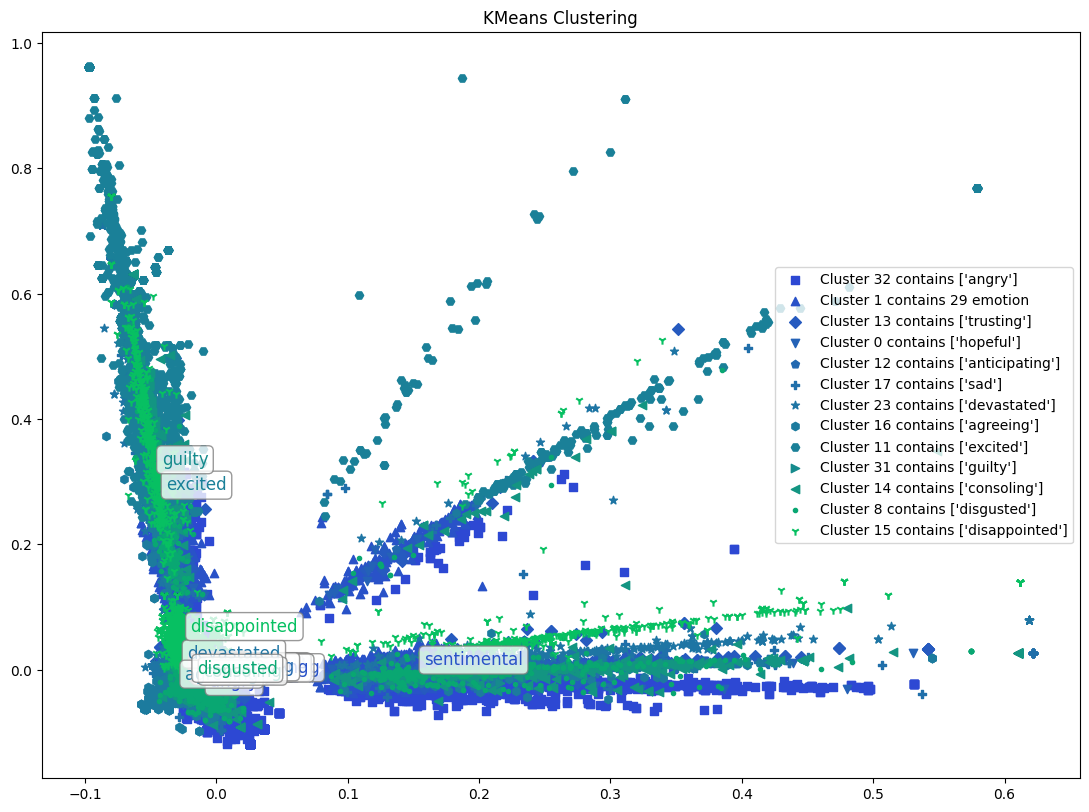

In [ ]:
# Reduce the dimensionality of the data to two dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xf.toarray())

# Define a list of markers and colors to use for the scatter plot
markers = ["o", "s", "^", "D", "v", "p", "P", "*", "h", "H", ">", "<", ".", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "d"]
colors = ['#3b1dff', '#2d48d3', '#2952c8', '#265abf', '#2462b7', '#2268b0', '#206faa', '#1e75a4', '#1c7b9e', '#1a8098', '#168b8d', '#139582', '#09a772', '#07c062']

# Set the size of the figure
plt.figure(figsize=(11, 8))

# Plot the data points with different colors and markers corresponding to their cluster labels
i=1
for cluster, topics in cluster_topics.items():
    marker = markers[i % len(markers)]
    color = colors[i % len(colors)]
    if len(topics) > 2:
      plt.scatter(X_pca[labels == cluster, 0], X_pca[labels == cluster, 1], c=color, marker=marker, label="Cluster {} contains {} emotion".format(cluster,len(topics)))
    else:
      plt.scatter(X_pca[labels == cluster, 0], X_pca[labels == cluster, 1], c=color, marker=marker, label="Cluster {} contains {}".format(cluster,topics))

    # Annotate the scatter plot with the topic names
    for j, topic in enumerate(emotions):
        if topic_map[topic] == cluster:
            x, y = X_pca[j, 0], X_pca[j, 1]
            plt.annotate(topic, xy=(x, y), xytext=(5, 5), textcoords="offset points", fontsize=12, color=color,
                        bbox=dict(boxstyle="round", fc="white", ec="gray", lw=1, alpha=0.8))
    i = i+1
        
# Adjust the plot to ensure that the bounding boxes don't overlap
plt.tight_layout()
plt.savefig("scatter_plot.png", dpi=300, bbox_inches="tight")

# Add a legend to the plot
plt.legend(loc="best")

plt.title("KMeans Clustering")

Also from the graph we can see that the clusters are not well identified.

To have a better idea of how KMeans performed in our task, let's compute extrisinc evaluation metrics.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(tokens_df['eb+_emot'], kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(tokens_df['eb+_emot'], kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(tokens_df['eb+_emot'], kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(tokens_df['eb+_emot'], kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.06563872051104021
Completeness: 0.12161833478804444
V-measure: 0.08526110670084419
Adjusted Rand-Index: 0.0034418133560289764


As expected, results are not very accurate. This could be caused by many different characteristics of our dataset like for example non-spherical clusters or unequal cluster size or density. We probably need a more complex clustering algorithm

### **Clustering with LDA**

KMeans algorithm tries to associate each data point to a single cluster and in our case this may have been one of the reasons of its bad performance. Let's try to generate again the clusters by using Latent Dirichlet Allocation, which will associate each datapoints to a variety of topics (clusters) which could be useful in more complex datasets like ours.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler

# Convert the tokenized data to a bag-of-words representation using scikit-learn's CountVectorizer
vectorizer = CountVectorizer()
Xc = vectorizer.fit_transform(tokens_df['filtered_tokens'])

# Fit an LDA model to the bag-of-words data  
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(Xc)

LatentDirichletAllocation(n_components=41, random_state=42)

In [ ]:
# Get the topic distributions for the documents
topic_distributions = lda.transform(Xc)

# Perform dimensionality reduction with PCA
scaler = StandardScaler()
topic_distributions_scaled = scaler.fit_transform(topic_distributions)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(topic_distributions_scaled)

In [ ]:
pd.factorize(tokens_df['eb+_emot'])[0]

array([ 0,  0,  0, ..., 40, 40, 40])

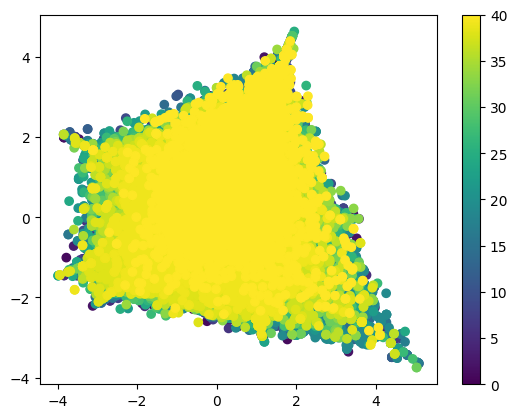

In [ ]:
# Plot the topic distributions in a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(tokens_df['eb+_emot'])[0], cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
import pandas as pd

In [ ]:
corpus = Sparse2Corpus(Xf, documents_columns=False)
dictionary = Dictionary.from_corpus(corpus, id2word=dict((i,word) for i, word in enumerate(tfidf_vec.get_feature_names_out())))

In [ ]:
# Train the LDA model on the corpus
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10)

In [ ]:
# Print the topics and their keywords
for topic in lda_model.print_topics():
    print(topic)

# Visualize the topics with a graph
topics = lda_model.show_topics(formatted=False)
fig, ax = plt.subplots(figsize=(8, 6))
for topic in topics:
    x = [word[0] for word in topic[1]]
    y = [word[1] for word in topic[1]]
    ax.plot(x, y, label='Topic ' + str(topic[0]))
ax.legend()
plt.xlabel('Word')
plt.ylabel('Probability')
plt.show()

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA

# Define the number of topics and iterations for LDA
num_topics = 41
max_iterations = 10

# Create a CountVectorizer object to convert text to a bag-of-words vector
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")

# Fit the CountVectorizer model to the data
cv_model = cv.fit(df_spark_lda)

# Transform the data using the CountVectorizer model
df_features = cv_model.transform(df_spark_lda)

# Create an IDF object to compute the TF-IDF weights
idf = IDF(inputCol="raw_features", outputCol="features")

# Fit the IDF model to the data
idf_model = idf.fit(df_features)

# Transform the data using the IDF model
df_tfidf = idf_model.transform(df_features)

# Create an LDA object and set its parameters
lda = LDA(k=num_topics, maxIter=max_iterations)

# Fit the LDA model to the data
lda_model = lda.fit(df_tfidf)

# Extract the top words in each topic
topics = lda_model.describeTopics(maxTermsPerTopic=10)

# Show the top words in each topic
topics.show()

In [ ]:
df_topics.show()

In [ ]:
# Extract the topic distributions for each document
df_topics = lda_model.transform(df_tfidf)

# Convert the topic distributions to a numpy array
topics = np.array(df_topics.select("topicDistribution").rdd.map(lambda x: x[0]).collect())

# Use a LabelEncoder to convert the topic labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_topics.select("eb+_emot").rdd.map(lambda x: x[0]).collect())

# Reduce the dimensionality of the topic distributions using PCA
pca = PCA(n_components=2, random_state=42)
topics_pca = pca.fit_transform(topics)

In [ ]:
# Create a scatter plot of the PCA embeddings
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(topics_pca[:, 0], topics_pca[:, 1], c=labels)
ax.set_title("LDA Clustering with PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

In [ ]:
print(len(labels))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a scatter plot of the PCA embeddings with a larger plot size
fig, ax = plt.subplots(figsize=(12, 10))
# Plot the markers and annotate them with text labels
for i in range(num_topics):
    ax.scatter(topics_pca[labels==i, 0], topics_pca[labels==i, 1], s=50, cmap='viridis', alpha=0.5, label="Cluster "+str(i))
    ax.annotate(str(i), (topics_pca[i, 0], topics_pca[i, 1]))
ax.set_title("LDA Clustering with PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
fig.colorbar(scatter)
plt.show()

In [ ]:
%%capture
!pip install pyspark

In [ ]:
# Create a SparkSession
spark_lda = SparkSession.builder.appName('LDA_clustering').config("spark.executor.memory", "8g").config("spark.executor.instances", "4").config("spark.hadoop.fs.defaultFS", "hdfs://namenode:8020").getOrCreate()

In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_spark_lda = spark_lda.createDataFrame(tokens_df)

# Show the first few rows of the Spark DataFrame
df_spark_lda.show(truncate=False)

In [ ]:
# Remove brackets and quotes from filtered_tokens column
df_spark_lda = df_spark_lda.withColumn("filtered_tokens", regexp_replace(col("filtered_tokens"), "[\[\]\']", ""))

# Split filtered_tokens column on commas to create an array of strings
df_spark_lda = df_spark_lda.withColumn("filtered_tokens", split(col("filtered_tokens"), ", "))

# Show the first few rows of the Spark DataFrame
df_spark_lda.show(truncate=False)

In [ ]:
# Compute the term frequency of the words
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features", minDF=min_doc_freq, maxDF=max_doc_freq)
vectorizerModel  = vectorizer.fit(df_spark_lda)
df_vectorized = vectorizerModel.transform(df_spark_lda)

In [ ]:
# Compute the IDF (inverse document frequency) of the words
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(df_vectorized)
df_features = idfModel.transform(df_vectorized)

In [ ]:
df_features.cache()

lda = LDA(k=n_topics, maxIter=10, optimizer="online", featuresCol="features")

df_features.unpersist()

In [ ]:
# Tune the hyperparameters of the LDA algorithm
lda = LDA(k=n_topics, maxIter=10, optimizer="online", featuresCol="features")

# Fit the LDA model
lda_model = lda.fit(df_features)

In [ ]:
topics.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top words in each topic
topics = lda_model.describeTopics(maxTermsPerTopic=10)

# Extract the top words and their probabilities
words = topics.select("termIndices").rdd.flatMap(lambda x: x).collect()
probs = topics.select("termWeights").rdd.flatMap(lambda x: x).collect()

# Check if there are any topics
num_topics = len(words) // 10
if num_topics == 0:
    print("No topics found")
else:
    # Create a horizontal bar chart for each topic
    fig, axs = plt.subplots(num_topics, 1, figsize=(6, num_topics * 0.5))

    for i in range(num_topics):
        # Get the top words and their probabilities for this topic
        topic_words = [vocab[int(idx)] for idx in words[i*10:(i+1)*10]]
        topic_probs = probs[i*10:(i+1)*10]

        # Plot the top words and their probabilities as a horizontal bar chart
        y_pos = np.arange(len(topic_words))
        axs[i].barh(y_pos, topic_probs, align='center')
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(topic_words)
        axs[i].invert_yaxis() 
        axs[i].set_xlabel('Probability')
        axs[i].set_title('Topic ' + str(i+1))

    plt.tight_layout()
    plt.show()

In [ ]:
# Fit a CountVectorizer model to the tokenized data
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
vectorizerModel = vectorizer.fit(df_spark_lda)
countVectors = vectorizerModel.transform(df_spark_lda).select("eb+_emot", "features")

# Train an LDA model on the count vectors
num_topics = 6
lda = LDA(k=num_topics, maxIter=10)
lda_model = lda.fit(countVectors)

# Transform the count vectors into a DataFrame of topic distributions
transformed = lda_model.transform(countVectors)
topic_distribution = transformed.select("eb+_emot", "topicDistribution")

# Join the topic distribution DataFrame with the original DataFrame
result = df_spark_lda.join(topic_distribution, "eb+_emot")
result.show()

In [ ]:
# Get the topics and their associated word distributions
topics = lda_model.describeTopics(maxTermsPerTopic=10)

# Arrange the graphs in a 7x6 grid
fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(20, 20))

# Plot the word distributions for each topic
for i in range(topics.count()):
    row = i // 6
    col = i % 6
    topic = topics.select("termWeights", "termIndices").where(f"topic = {i}").first()
    weights = topic['termWeights']
    words = [vectorizerModel.vocabulary[idx] for idx in topic['termIndices']]
    axs[row, col].bar(words, weights)
    axs[row, col].set_title("Topic " + str(i))
    plt.setp(axs[row, col].get_xticklabels(), rotation="vertical")

# Hide unused subplots
for i in range(topics.count(), 7 * 6):
    row = i // 6
    col = i % 6
    axs[row, col].axis('off')

# Display the graphs
plt.tight_layout()
plt.show()

In [ ]:
topics = lda_model.describeTopics(maxTermsPerTopic=10)
vocabulary = vectorizerModel.vocabulary
for row in topics.rdd.collect():
    print("Topic: {}".format(row.topic))
    for i in range(len(row.termIndices)):
        print("{}: {}".format(vocabulary[row.termIndices[i]], row.termWeights[i]))
    print("\n")

In [ ]:
import pyLDAvis
print(pyLDAvis.__version__)

In [ ]:
!pip install scikit-learn
!pip install pyLDAvis

In [ ]:
import pyLDAvis

# Extract the topic-term distributions and document-topic distributions from the LDA model
topic_term_dists = lda_model.topicsMatrix().toArray().T
doc_topic_dists = lda_model.transform(df_features).select("topicDistribution").rdd.map(lambda x: x[0].toArray()).collect()

# Convert the document-term matrix back to a format that can be used by PyLDAVis
vocab = vectorizerModel.vocabulary
doc_lengths = df_features.selectExpr("size(filtered_tokens) as doc_length").rdd.map(lambda x: x[0]).collect()
term_frequency = df_features.select("features").rdd.flatMap(lambda x: x[0].toArray()).collect()

# Create a Pandas DataFrame from the PySpark DataFrame
data_pandas = df_features.toPandas()

# Define a function to convert the PySpark DataFrame to a format that can be used by PyLDAVis
def get_document_topic_distribution(doc_topic_distribution):
    return list(doc_topic_distribution)

udf_get_document_topic_distribution = udf(get_document_topic_distribution, ArrayType(StringType()))
data_pandas['topicDistribution'] = data_pandas['topicDistribution'].apply(lambda x: [float(i) for i in x])
data_pandas['document_topic_distribution'] = data_pandas['topicDistribution'].apply(udf_get_document_topic_distribution)

# Visualize the topics using PyLDAVis
vis_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
pyLDAvis.display(vis_data)

## **Embeddings**

### **Word2Vec**

Let's prepare the dataset for the tokenization under a Word2Vec model. 
First we need to remove the non-alphabetic characters. 
We proceed by trasforming everything into lowercase, by removing punctuaction, and by removing sentences that are only 1 word long, since they won't be useful for training the model.

In [ ]:
from pandas.core.common import flatten

sentences = df['uttr']
sentences = list(flatten(sentences))
sentences[:20]

['You moron ! What fool washes diapers by the well !',
 'You useless fool !',
 'How dare you sleep !',
 'Up ! Go and clean the house .',
 'Clean the kitchen .',
 "I cleaned the kitchen , ma 'am .",
 'Your name means to trust . It also means truth . And endurance . Or it could be god .',
 "You were given a great name . You 'd better live up to it .",
 "I 'll go home in the spring once the snow melts .",
 "Listen . No matter how tough it gets I wouldn 't bring shame to you and your dad . I promise I won 't .",
 'Your medicine . Open your mouth .',
 'Granny ...',
 "Don 't spill it .",
 'Granny !',
 'Oshin .',
 "Brandon said he 's headed down to Galway .",
 "Craking , Galway , it 's the same thing . He 's really heading down there ...",
 'Hi there , Welcome to the Stockroom .',
 "I don 't really work here . I 've never even been to a store like this .",
 "Don 't get me wrong . I 'm not a prude . I like sex ."]

In [ ]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

Loading of the model.

In [ ]:
w2v_model = Word2Vec(sentences=tokenized_sentences,
                     min_count=20,
                     window=5,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [ ]:
len(w2v_model.wv)  #number of learned vectors

25983

Let's evaluate if the model has learned a significant embedding

In [ ]:
term = "moron"
w2v_model.wv.most_similar(term)

[('cunt', 0.716732382774353),
 ('idiot', 0.6909536719322205),
 ('faggot', 0.6816585063934326),
 ('retard', 0.6795588731765747),
 ('asshole', 0.679030179977417),
 ('fucking', 0.6769351363182068),
 ('prick', 0.6580446362495422),
 ('dickhead', 0.6530579924583435),
 ('cocksucker', 0.6490021347999573),
 ('mutt', 0.6460972428321838)]

Visualization of the representation space with TSNE

In [ ]:
sample = random.sample(list(w2v_model.wv.key_to_index), 500)
print(sample)

word_vectors = w2v_model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

['cig', 'willie', 'measured', 'poses', 'using', 'bandits', 'franc', 'ministers', 'snot', 'pappa', 'sessions', 'prudence', 'weenie', 'whores', 'picker', 'endings', 'trained', 'apricot', 'pepperoni', 'plotting', 'band', 'responsibilities', 'moons', 'widely', 'thunderstorm', 'screams', 'silicone', 'acceptable', 'dyke', 'robo', 'instantaneous', 'frogs', 'nightingale', 'cora', 'transmit', 'talyn', 'gwi', 'fireworks', 'analysis', 'pheasant', 'fie', 'entice', 'pressured', 'brownies', 'ruler', 'crumbled', 'guilders', 'loosened', 'warmth', 'mortis', 'brianna', 'evolution', 'comedy', 'brim', 'horrific', 'bodyguards', 'kidney', 'comm', 'cosima', 'alexandra', 'polls', 'gallop', 'pennsylvania', 'partners', 'chewing', 'delight', 'treat', 'aptitude', 'cinderella', 'ransom', 'wendell', 'eckhart', 'flavors', 'bulbs', 'scrap', 'arrangement', 'ethan', 'reshma', 'foremost', 'schizo', 'clarify', 'scruffy', 'dementia', 'settlements', 'legacy', 'ftl', 'healed', 'holloway', 't', 'ammo', 'aye', 'playtime', '40

In [ ]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

## **Indexing for Keyword Search**

In [ ]:
#TODO

# **Sentiment Analysis**

In this first part we will try many different Machine Learning models and compare the performance between TF-IDF and WordEmbedding vectorization approach.
We have three main challenges in this part:

- class imbalance
- dataset size
- hyperparameter tuning

We can't handle the whole dataset with the available resources, we will downsample it, keeping only a small portion. Since downsampling is often also used to resolve class imbalance problems,we will take advantage of that to mantain the same amount of data for each class of our problem.

For what regards hyperparameter tuning, we will use GridSearch with 5-Fold Cross Validation or Bayesian Optimization with HyperOpt Library.

For what regards evaluation, we will simply split the dataset between train set and test set (20%), avoiding validation set.
When we will train deep learning models instead we will split between train and validation set to use learning rate schedulers, early stopping and other tools to improve performance of the model based on validation loss.

## **Training and Evaluation with TF-IDF Vectorization**

In [ ]:
X = final_df['cleaned_text']
y = final_df['eb+_emot']

### **Train, Test Splitting**

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

### **Vectorization with TF-IDF**

As before (Clustering section) we will preprocess and vectorize the corpus but this time we will also vectorize the labels.

After some tests, we found out that keeping both generic and corpus-specific stopwords gives a significant boost to the performance. This is an expected behaviour since most of the sentences in the dataset are quite short and often contain 1 or more stopwords. Removing them causes a massive reduction of informations.

Observe this example to better understand this concept:

Let's suppose that we have a sentence
"Are you my real father, Ben?" that has 'questioning' as the target value.
If we apply stopwords and punctuation removal it becomes:
"real father ben"
which is quite ambiguous.

The ambiguity is given by the fact that the whole sentence could also have been
"You cannot be my real father, Ben!" that has 'angry' or 'furious' as the target value.


For what regards corpus-specific words, they mostly were noise in the full dataset, but, given our downsampled split, they probably represent some useful information for the classifiers.


In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words=None,
                            lowercase=True,
                            min_df=30,
                            max_df=1.0,
                            dtype=float32
                           )

Best performance is given by min_df = 0 and max_df = 1.0, which means that no words are removed. In that case we would have a vocabulary of roughly 80k terms and a terrible performance/training time ratio, so we set min_df = 30, which reduces vocabulary to roughly 5k terms and improves greatly the training time while mantaining almost unchanged the performance of the classifiers.

In [ ]:
train_x = tfidf_vec.fit_transform(train_x)
test_x = tfidf_vec.transform(test_x)

In [ ]:
tfidf_vec.get_feature_names_out()

array(['aah', 'aaron', 'abandon', ..., 'zombie', 'zone', 'zoo'],
      dtype=object)

In [ ]:
train_x.shape

(281358, 5587)

We now need to encode labels. To do that we can use Label Encoding, which associates a integer number to each class,so in our case each one of our emotions will be mapped to a number between 0 and 40.
In alternative we also can use One-Hot Encoding, which transforms each class to a sparse one-hot encoded vector.

Label Encoding introduces a problem because the model may derive a ordinal correlation of some sort due to the fact that labels are mathematically related (i.e: if 0 is cat, 1 is dog and 2 is tiger, the model could derive that average between cat and tiger is dog whic is obviously wrong).

In multi-class sentiment analysis both encodings are interesting but after some tests we found out that label encoding works best, capturing the intuitive ordinal relationship between the emotions (i.e: angry is 0, furious is 1 so furious > angry).

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

### **Linear Classifier**

#### **Multinomial Logistic Regression**

Since the original Logistic Regression model was made with binary classification problems in mind, it doesn't natively support multi classification problems. However, SKLearn implementation supports multiclass problem, so we are going to use Multinomial Logistic Regression, which is a single classifier, instead of  OneVSRest or OneVSOne approaches.

In [ ]:
params = {'n_jobs':[-1],
          'multi_class':['multinomial'],
          'solver':['saga'],
          'C':[1,0.1,0.01],
          'max_iter':[100],
          'penalty':['l1','l2']}

In [ ]:
log_reg = LogisticRegression()

In [ ]:
gs = GridSearchCV(log_reg,params,cv=2,scoring='accuracy')

In [ ]:
gs.fit(train_x,train_y)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [1, 0.1, 0.01], 'max_iter': [100],
                         'multi_class': ['multinomial'], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='accuracy')

In [ ]:
print(f"The best parameters are {gs.best_params_}")

The best parameters are {'C': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
y_pred = gs.predict(test_x)

In [ ]:
print(classification_report(test_y,y_pred))

               precision    recall  f1-score   support

acknowledging       0.38      0.39      0.38      1716
       afraid       0.65      0.55      0.60      1716
     agreeing       0.48      0.47      0.48      1716
        angry       0.63      0.53      0.57      1716
      annoyed       0.51      0.50      0.50      1715
 anticipating       0.51      0.56      0.54      1716
      anxious       0.69      0.69      0.69      1715
 apprehensive       0.53      0.56      0.54      1716
      ashamed       0.57      0.51      0.54      1715
       caring       0.49      0.50      0.49      1715
    confident       0.43      0.40      0.41      1716
    consoling       0.65      0.62      0.64      1716
      content       0.59      0.61      0.60      1715
   devastated       0.59      0.57      0.58      1715
 disappointed       0.59      0.57      0.58      1716
    disgusted       0.73      0.72      0.72      1715
  embarrassed       0.77      0.59      0.67      1716
  encoura

### **Random Forest Classifier**

In [ ]:
search_space = {
    'bootstrap': True,
    'max_features': 'sqrt',
    'min_samples_leaf': hp.quniform('min_samples_leaf',1, 5,1),
    'min_samples_split': hp.quniform('min_samples_split',1, 4,1),
    'n_estimators': 100
}

In [ ]:
def hyperparameter_tuning(space):
    random_forest = RandomForestClassifier(bootstrap=space['bootstrap'],
                                          max_depth=None,
                                          max_features=space['max_features'],
                                          min_samples_leaf=int(space['min_samples_leaf']),
                                          min_samples_split=int(space['min_samples_split']))

    random_forest.fit(train_x, train_y)

    y_pred = random_forest.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': random_forest}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

In [ ]:
random_forest = RandomForestClassifier(max_depth=None,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       bootstrap=True,
                                       max_features='sqrt',
                                       n_estimators=100)
random_forest.fit(train_x,train_y)
y_pred = random_forest.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.35      0.38      1716
           1       0.66      0.55      0.60      1716
           2       0.46      0.46      0.46      1716
           3       0.63      0.52      0.57      1716
           4       0.46      0.42      0.44      1715
           5       0.47      0.51      0.49      1716
           6       0.77      0.79      0.78      1715
           7       0.42      0.62      0.50      1716
           8       0.66      0.56      0.61      1715
           9       0.44      0.46      0.45      1715
          10       0.37      0.35      0.36      1716
          11       0.74      0.72      0.73      1716
          12       0.62      0.58      0.60      1715
          13       0.64      0.57      0.60      1715
          14       0.56      0.62      0.59      1716
          15       0.69      0.65      0.67      1715
          16       0.82      0.58      0.68      1716
          17       0.75    

### **XGB Classifier**

XGBoost is an ensemble algorithm, in particular a boosting one. It has the reputation of being one of the most effective ML algorithm for both regression and classification and it's often used in Kaggle Competitions with good results. Thank to GPU acceleration we can train a XGB instance in few minutes so we will tune its hyperparameters using Bayesian Optimization which differs from GridSearch and RandomSearch for being an informed search algorithm, which uses previous iterations to decide where to search next in the search space. For this reason a single iteration is usually longer than the ones on uninformed algorithms like grid search but it usually converges faster to good solutions.

In [ ]:
search_space={'max_depth': hp.quniform("max_depth", 8, 12, 1),
              'gamma': 0.5,
              'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
              'reg_lambda' : hp.uniform('reg_lambda', 0,1),
              'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
              'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
              'learning_rate':hp.uniform('learning_rate',0.01,0.2),
              'n_estimators': 350 }

In [ ]:
def hyperparameter_tuning(space):
    xgb = XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],tree_method='gpu_hist',gpu_id=0,objective='multi:softmax',
                         learning_rate=space['learning_rate'])   
    xgb.fit(train_x, train_y)

    y_pred = xgb.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': xgb}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

In [ ]:
xgb = XGBClassifier(n_estimators=350,
                    max_depth=8,
                    gamma=0.5,
                    verbosity = 0,
                    tree_method='gpu_hist', 
                    gpu_id=0,
                    objective='multi:softmax')  #0.43
xgb.fit(train_x, train_y)

y_pred = xgb.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41      1716
           1       0.68      0.61      0.64      1716
           2       0.51      0.49      0.50      1716
           3       0.65      0.56      0.60      1716
           4       0.53      0.48      0.50      1715
           5       0.54      0.54      0.54      1716
           6       0.78      0.78      0.78      1715
           7       0.55      0.60      0.57      1716
           8       0.63      0.56      0.59      1715
           9       0.53      0.52      0.53      1715
          10       0.43      0.41      0.42      1716
          11       0.72      0.70      0.71      1716
          12       0.63      0.65      0.64      1715
          13       0.63      0.61      0.62      1715
          14       0.64      0.65      0.64      1716
          15       0.71      0.66      0.69      1715
          16       0.77      0.64      0.70      1716
          17       0.74    

### **Neural Networks**

Before feeding our data to the neural networks, we need to convert them to numpy arrays and since we only have 30 GB RAM, we also need to reduce their size by converting all the vectors from float32 to float16 to reduce the amount of RAM occupied by the arrays while they stay in memory during training and inference of our models.


We will also pick the first 20% of the test data to create a validation set that we will use to adjust learning rate and other parameters during the training phase.

In [ ]:
train_x = train_x.toarray()
test_x = test_x.toarray()

In [ ]:
train_x = train_x.astype("float16")
test_x = test_x.astype("float16")

In [ ]:
full_size = test_x.shape[0]
val_size = 0.2
val_x = test_x[:int(val_size*full_size)]
test_x = test_x[int(val_size*full_size)+1:]

In [ ]:
val_y = test_y[:int(val_size*full_size)]
test_y = test_y[int(val_size*full_size)+1:]

In [ ]:
val_x.shape

(14068, 5516)

In [ ]:
test_x.shape

(56271, 5516)

#### **Artificial Neural Network**

In [ ]:
dropout_rate = 0.2

In [ ]:
vocab_size = tfidf_vec.get_feature_names_out().size

As first model, we will build,train and evaluate a simple ANN, made of 2 Dense layers with 64 neurons each, plus the classification head that will produce the probabilities by applying softmax activation function to the input logits.

As regularization technique, we will also add two Dropout layers with rate=0.2. This means that at each iteration, 20% of the neurons of the layer on which dropout is applied won't be used. In this way the model should be able to better generalize on unseen data and reduce overfitting as a consequence.

In [ ]:
model = Sequential()
model.add(Dense(64,input_dim=vocab_size,activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(64,activation="relu"))
model.add(Dropout(dropout_rate))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(x=train_x,y=train_y,validation_data=(val_x,val_y),epochs=60,callbacks=[lr_sched,mdl_check,early_stop],batch_size=32)

In [ ]:
model.evaluate(x=test_x,y=test_y)

1759/1759 [==============================] - 6s 3ms/step - loss: 1.7009 - accuracy: 0.5813


[1.700945258140564, 0.5812585353851318]

#### **LSTM Neural Network**

Let's try to add three Bidirectional LSTM (Long Short Term Memory) layers, to see if we can outperform the XGBoost algorithm.
As regularization we will use dropout just like before and also add layer weight constraints.

In [ ]:
train_x = train_x.reshape(-1,1,vocab_size)
test_x = test_x.reshape(-1,1,vocab_size)
val_x = val_x.reshape(-1,1,vocab_size)

In [ ]:
train_x.shape

(281358, 1, 5516)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(96,return_sequences=True,input_shape=(1,vocab_size))))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(96,return_sequences=True,kernel_initializer='normal',kernel_constraint=max_norm(5))))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(96,return_sequences=False,kernel_initializer='normal',kernel_constraint=max_norm(5))))
model.add(Dropout(dropout_rate))
model.add(Dense(64,activation="relu",kernel_initializer='normal',kernel_constraint=max_norm(5)))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(x=train_x,y=train_y,epochs=90,validation_data=(val_x,val_y),callbacks=[lr_sched,mdl_check,early_stop],batch_size=64)

2023-05-03 18:01:02.644498: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6207882912 exceeds 10% of free system memory.
2023-05-03 18:01:09.266733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6207882912 exceeds 10% of free system memory.


Epoch 1/90
4397/4397 [==============================] - ETA: 0s - loss: 2.5472 - accuracy: 0.2984
Epoch 1: val_accuracy improved from -inf to 0.40468, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 133s 27ms/step - loss: 2.5472 - accuracy: 0.2984 - val_loss: 2.1482 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 2/90
4397/4397 [==============================] - ETA: 0s - loss: 1.9597 - accuracy: 0.4539
Epoch 2: val_accuracy improved from 0.40468 to 0.49680, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 114s 26ms/step - loss: 1.9597 - accuracy: 0.4539 - val_loss: 1.8043 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 3/90
4396/4397 [============================>.] - ETA: 0s - loss: 1.6898 - accuracy: 0.5228
Epoch 3: val_accuracy improved from 0.49680 to 0.53846, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 1.6898 - accuracy: 0.5228 - val_loss: 1.6571 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 4/90
4397/4397 [==============================] - ETA: 0s - loss: 1.5374 - accuracy: 0.5616
Epoch 4: val_accuracy improved from 0.53846 to 0.55864, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 120s 27ms/step - loss: 1.5374 - accuracy: 0.5616 - val_loss: 1.5724 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 5/90
4397/4397 [==============================] - ETA: 0s - loss: 1.4244 - accuracy: 0.5917
Epoch 5: val_accuracy improved from 0.55864 to 0.57279, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 120s 27ms/step - loss: 1.4244 - accuracy: 0.5917 - val_loss: 1.5293 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 6/90
4396/4397 [============================>.] - ETA: 0s - loss: 1.3216 - accuracy: 0.6195
Epoch 6: val_accuracy improved from 0.57279 to 0.58246, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 1.3216 - accuracy: 0.6195 - val_loss: 1.4982 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 7/90
4394/4397 [============================>.] - ETA: 0s - loss: 1.2275 - accuracy: 0.6449
Epoch 7: val_accuracy improved from 0.58246 to 0.59070, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 117s 27ms/step - loss: 1.2275 - accuracy: 0.6449 - val_loss: 1.4898 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 8/90
4397/4397 [==============================] - ETA: 0s - loss: 1.1370 - accuracy: 0.6704
Epoch 8: val_accuracy improved from 0.59070 to 0.59440, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 111s 25ms/step - loss: 1.1370 - accuracy: 0.6704 - val_loss: 1.4754 - val_accuracy: 0.5944 - lr: 0.0010
Epoch 9/90
4396/4397 [============================>.] - ETA: 0s - loss: 1.0547 - accuracy: 0.6919
Epoch 9: val_accuracy improved from 0.59440 to 0.60016, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 113s 26ms/step - loss: 1.0547 - accuracy: 0.6919 - val_loss: 1.4962 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 10/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.9779 - accuracy: 0.7134
Epoch 10: val_accuracy improved from 0.60016 to 0.60890, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 0.9779 - accuracy: 0.7134 - val_loss: 1.5247 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 11/90
4397/4397 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.7321
Epoch 11: val_accuracy improved from 0.60890 to 0.60904, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 0.9116 - accuracy: 0.7321 - val_loss: 1.5482 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 12/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.8505 - accuracy: 0.7490
Epoch 12: val_accuracy improved from 0.60904 to 0.61032, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 0.8505 - accuracy: 0.7490 - val_loss: 1.5902 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 13/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.7983 - accuracy: 0.7637
Epoch 13: val_accuracy improved from 0.61032 to 0.61480, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 109s 25ms/step - loss: 0.7983 - accuracy: 0.7637 - val_loss: 1.6291 - val_accuracy: 0.6148 - lr: 0.0010
Epoch 14/90
4397/4397 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.7750
Epoch 14: val_accuracy did not improve from 0.61480
4397/4397 [==============================] - 74s 17ms/step - loss: 0.7560 - accuracy: 0.7750 - val_loss: 1.6855 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 15/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.7156 - accuracy: 0.7872
Epoch 15: val_accuracy improved from 0.61480 to 0.61608, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 0.7155 - accuracy: 0.7872 - val_loss: 1.7376 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 16/90
4397/4397 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.7962
Epoch 16: val_accuracy did not improve from 0.61608
4397/4397 [==============================] - 79s 18ms/step - loss: 0.6821 - accuracy: 0.7962 - val_loss: 1.7732 - val_accuracy: 0.6141 - lr: 0.0010
Epoch 17/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.6537 - accuracy: 0.8047
Epoch 17: val_accuracy did not improve from 0.61608
4397/4397 [==============================] - 81s 18ms/step - loss: 0.6537 - accuracy: 0.8047 - val_loss: 1.8198 - val_accuracy: 0.6153 - lr: 0.0010
Epoch 18/90
4397/4397 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.8112
Epoch 18: val_accuracy did not improve from 0.61608
4397/4397 [==============================] - 81s 18ms/step - loss: 0.6294 - accuracy: 0.8112 - val_los

INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 121s 27ms/step - loss: 0.5849 - accuracy: 0.8246 - val_loss: 1.9827 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 21/90
4394/4397 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.8290
Epoch 21: val_accuracy did not improve from 0.61643
4397/4397 [==============================] - 77s 17ms/step - loss: 0.5695 - accuracy: 0.8291 - val_loss: 1.9954 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 22/90
4394/4397 [============================>.] - ETA: 0s - loss: 0.5527 - accuracy: 0.8341
Epoch 22: val_accuracy improved from 0.61643 to 0.61693, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 114s 26ms/step - loss: 0.5527 - accuracy: 0.8341 - val_loss: 1.9850 - val_accuracy: 0.6169 - lr: 0.0010
Epoch 23/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.8377
Epoch 23: val_accuracy did not improve from 0.61693
4397/4397 [==============================] - 75s 17ms/step - loss: 0.5381 - accuracy: 0.8377 - val_loss: 2.0604 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 24/90
4397/4397 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.8426
Epoch 24: val_accuracy did not improve from 0.61693
4397/4397 [==============================] - 76s 17ms/step - loss: 0.5218 - accuracy: 0.8426 - val_loss: 2.1014 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 25/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.5120 - accuracy: 0.8456
Epoch 25: val_accuracy did not improve from 0.61693
4397/4397 [==============================] - 76s 17ms/step - loss: 0.5120 - accuracy: 0.8456 - val_los

INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 117s 27ms/step - loss: 0.4313 - accuracy: 0.8710 - val_loss: 2.2878 - val_accuracy: 0.6183 - lr: 1.0000e-04
Epoch 29/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.4224 - accuracy: 0.8728
Epoch 29: val_accuracy improved from 0.61828 to 0.62006, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 120s 27ms/step - loss: 0.4224 - accuracy: 0.8728 - val_loss: 2.3026 - val_accuracy: 0.6201 - lr: 1.0000e-04
Epoch 30/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.4137 - accuracy: 0.8756
Epoch 30: val_accuracy did not improve from 0.62006
4397/4397 [==============================] - 74s 17ms/step - loss: 0.4137 - accuracy: 0.8756 - val_loss: 2.3482 - val_accuracy: 0.6194 - lr: 1.0000e-04
Epoch 31/90
4397/4397 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8774
Epoch 31: val_accuracy did not improve from 0.62006
4397/4397 [==============================] - 74s 17ms/step - loss: 0.4084 - accuracy: 0.8774 - val_loss: 2.3782 - val_accuracy: 0.6192 - lr: 1.0000e-04
Epoch 32/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.4078 - accuracy: 0.8773
Epoch 32: val_accuracy did not improve from 0.62006
4397/4397 [==============================] - 75s 17ms/step - loss: 0.4077 - accuracy: 0.87

INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 110s 25ms/step - loss: 0.3989 - accuracy: 0.8798 - val_loss: 2.3963 - val_accuracy: 0.6204 - lr: 1.0000e-04
Epoch 35/90
4394/4397 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8810
Epoch 35: val_accuracy did not improve from 0.62042
4397/4397 [==============================] - 76s 17ms/step - loss: 0.3965 - accuracy: 0.8810 - val_loss: 2.4088 - val_accuracy: 0.6199 - lr: 1.0000e-04
Epoch 36/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8813
Epoch 36: val_accuracy improved from 0.62042 to 0.62091, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 112s 25ms/step - loss: 0.3955 - accuracy: 0.8813 - val_loss: 2.4151 - val_accuracy: 0.6209 - lr: 1.0000e-04
Epoch 37/90
4394/4397 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8819
Epoch 37: val_accuracy improved from 0.62091 to 0.62098, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 119s 27ms/step - loss: 0.3935 - accuracy: 0.8819 - val_loss: 2.4276 - val_accuracy: 0.6210 - lr: 1.0000e-04
Epoch 38/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8829
Epoch 38: val_accuracy did not improve from 0.62098
4397/4397 [==============================] - 82s 19ms/step - loss: 0.3915 - accuracy: 0.8829 - val_loss: 2.4170 - val_accuracy: 0.6196 - lr: 1.0000e-04
Epoch 39/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3890 - accuracy: 0.8836
Epoch 39: val_accuracy improved from 0.62098 to 0.62219, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 115s 26ms/step - loss: 0.3890 - accuracy: 0.8836 - val_loss: 2.4500 - val_accuracy: 0.6222 - lr: 1.0000e-04
Epoch 40/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3864 - accuracy: 0.8839
Epoch 40: val_accuracy did not improve from 0.62219
4397/4397 [==============================] - 76s 17ms/step - loss: 0.3864 - accuracy: 0.8839 - val_loss: 2.4565 - val_accuracy: 0.6197 - lr: 1.0000e-04
Epoch 41/90
4397/4397 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8841
Epoch 41: val_accuracy did not improve from 0.62219
4397/4397 [==============================] - 80s 18ms/step - loss: 0.3870 - accuracy: 0.8841 - val_loss: 2.4615 - val_accuracy: 0.6210 - lr: 1.0000e-04
Epoch 42/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3838 - accuracy: 0.8844
Epoch 42: val_accuracy improved from 0.62219 to 0.62269, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


4397/4397 [==============================] - 116s 26ms/step - loss: 0.3838 - accuracy: 0.8844 - val_loss: 2.4596 - val_accuracy: 0.6227 - lr: 1.0000e-04
Epoch 43/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8852
Epoch 43: val_accuracy did not improve from 0.62269
4397/4397 [==============================] - 78s 18ms/step - loss: 0.3814 - accuracy: 0.8852 - val_loss: 2.4671 - val_accuracy: 0.6221 - lr: 1.0000e-04
Epoch 44/90
4396/4397 [============================>.] - ETA: 0s - loss: 0.3805 - accuracy: 0.8856
Epoch 44: val_accuracy did not improve from 0.62269
4397/4397 [==============================] - 79s 18ms/step - loss: 0.3805 - accuracy: 0.8856 - val_loss: 2.4882 - val_accuracy: 0.6211 - lr: 1.0000e-04
Epoch 45/90
4395/4397 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8855
Epoch 45: val_accuracy did not improve from 0.62269
4397/4397 [==============================] - 78s 18ms/step - loss: 0.3798 - accuracy: 0.88

In [ ]:
model.evaluate(x=test_x,y=test_y)

1759/1759 [==============================] - 12s 7ms/step - loss: 2.3724 - accuracy: 0.6207


[2.3724429607391357, 0.620657205581665]

## **Training and Evaluation with Word2Vec Embeddings**

In this section, we will train all the models again by using Word2Vec Embeddings and compare the results.An embedding maps a word to a semantic vector. We call those semantic vector because they preserve semantic information related to the word they represent.In particular, words with a semantic relationship correspond to vectors that are close together in the vector space. They usually perform better than TF-IDF,BoW and similar. The main reasons are two:

- dense vectors vs sparse vectors: Embeddings are much smaller than sparse encoding methods since they produce dense vectors so training and inference are usually faster.

- semantic information is preserved: Sparse encoding methods only use frequency to encode words, while with embeddings, the semantic meaning of the input is kept and can be used to boost the performance of the model.

To produce our Word2Vec embeddings we will use SpaCy, a powerful open-source NLP library, which is broadly used in the industry due to its fast performance. In particular, we will perform Sentence Encoding, which produces a vector for each utterance in the dataset, by averaging the embeddings for each single word of the sentence. This approach is usually preferred in text-classification where we focus on the whole sentence meaning, while word-level embeddings performs better where more granular understanding is required like in PoS or Entity Recognition.

In [ ]:
X = final_df['cleaned_text']
y = final_df['eb+_emot']

### **Sentence Encoding with SpaCy**

In [ ]:
!python -m spacy download en_core_web_lg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

embedding_dim = len(nlp('The').vector)

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

For each utterance in the dataset, we compute its sentence encoding. Given the amount of data at our disposition this operation will require some time so we will save the resulting vectors to be able to load them at any point without computing all the embeddings again.

In [ ]:
train_x = [nlp(text).vector for text in train_x] #we get a list of vectors, where each vector is the sentence encoding
train_x=vstack(train_x)

In [ ]:
test_x = [nlp(text).vector for text in test_x] #we get a list of vectors, where each vector is the sentence encoding
test_x=vstack(test_x)

In [ ]:
test_x.shape

(70340, 300)

In [ ]:
train_x.shape

(281358, 300)

As we can see we obtained a list of sentence encodings, one for each entry in the dataset. Each encoding is composed by 300 float32.

In [ ]:
save("sent_encodings_newpreprocess/train.npy", train_x, allow_pickle=True, fix_imports=True)
save("sent_encodings_newpreprocess/test.npy", test_x, allow_pickle=True, fix_imports=True)

---
From now on we will load the computed matrix as numpy arrays from local disk to avoid recomputing them each time

In [ ]:
train_x = load("sent_encodings_newpreprocess/train.npy",allow_pickle=True)
test_x = load("sent_encodings_newpreprocess/test.npy",allow_pickle=True)

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

### **Linear Classifier**

#### **Multinomial Logistic Regression**

Since sentence encodings are dense vectors, they will take much more time than TF-IDF sparse compressed vectors. For this reason, even in case of a slightly improvement in the predictions, TF-IDF is probably the preferable approach.

Given the resources and the amount of data, we won't repeat the hyperparameter tuning, but instead, use the optimal parameters found in the TF-IDF Vectorization section.

In [ ]:
log_reg = LogisticRegression(n_jobs=-1,
                            multi_class='multinomial',
                            solver='saga',
                            C=1,
                            penalty='l2')

In [ ]:
log_reg.fit(train_x,train_y)

In [ ]:
y_pred = log_reg.predict(test_x)

In [ ]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.36      0.36      1716
           1       0.47      0.41      0.44      1716
           2       0.41      0.41      0.41      1716
           3       0.50      0.42      0.46      1716
           4       0.39      0.40      0.39      1715
           5       0.47      0.49      0.48      1716
           6       0.52      0.57      0.54      1715
           7       0.44      0.47      0.46      1716
           8       0.38      0.35      0.37      1715
           9       0.44      0.43      0.44      1715
          10       0.38      0.38      0.38      1716
          11       0.59      0.55      0.57      1716
          12       0.54      0.55      0.54      1715
          13       0.50      0.46      0.48      1715
          14       0.37      0.37      0.37      1716
          15       0.59      0.55      0.57      1715
          16       0.48      0.43      0.46      1716
          17       0.56    

### **Random Forest Classifier**

In [ ]:
random_forest = RandomForestClassifier(max_depth=None,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       bootstrap=True,
                                       max_features='sqrt',
                                       n_estimators=100,
                                       n_jobs=-1)
random_forest.fit(train_x,train_y)
y_pred = random_forest.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.33      0.36      1716
           1       0.34      0.25      0.29      1716
           2       0.46      0.33      0.38      1716
           3       0.61      0.40      0.48      1716
           4       0.37      0.36      0.37      1715
           5       0.36      0.38      0.37      1716
           6       0.60      0.69      0.64      1715
           7       0.32      0.52      0.39      1716
           8       0.55      0.49      0.51      1715
           9       0.34      0.40      0.37      1715
          10       0.34      0.26      0.29      1716
          11       0.64      0.63      0.63      1716
          12       0.46      0.37      0.41      1715
          13       0.63      0.49      0.55      1715
          14       0.44      0.46      0.45      1716
          15       0.55      0.61      0.58      1715
          16       0.47      0.45      0.46      1716
          17       0.66    

### **XGB Classifier**

In [ ]:
xgb = XGBClassifier(n_estimators=350,
                    max_depth=8,
                    gamma=0.5,
                    verbosity = 0,
                    tree_method='gpu_hist', 
                    gpu_id=0,
                    objective='multi:softmax')
xgb.fit(train_x, train_y)

y_pred = xgb.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.39      0.39      1716
           1       0.46      0.37      0.41      1716
           2       0.46      0.40      0.43      1716
           3       0.58      0.47      0.52      1716
           4       0.46      0.47      0.46      1715
           5       0.43      0.46      0.44      1716
           6       0.71      0.74      0.72      1715
           7       0.44      0.53      0.48      1716
           8       0.56      0.55      0.56      1715
           9       0.44      0.49      0.46      1715
          10       0.38      0.36      0.37      1716
          11       0.71      0.67      0.69      1716
          12       0.55      0.51      0.53      1715
          13       0.62      0.56      0.59      1715
          14       0.49      0.53      0.51      1716
          15       0.69      0.66      0.68      1715
          16       0.55      0.51      0.53      1716
          17       0.72    

### **Neural Networks**

#### **Artificial Neural Network**

In [ ]:
train_set = Dataset.from_tensor_slices((train_x,train_y))
test_set = Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
test_cardinality = experimental.cardinality(test_set)
val_set = test_set.take(test_cardinality // 5)
test_set = test_set.skip(test_cardinality // 5)

In [ ]:
train_set = train_set.shuffle(buffer_size=experimental.cardinality(train_set)).batch(32)
val_set = val_set.shuffle(buffer_size=experimental.cardinality(val_set)).batch(32)
test_set = test_set.shuffle(buffer_size = experimental.cardinality(test_set)).batch(32)

In [ ]:
embedding_dim = nlp('The').vector.size

In [ ]:
model = Sequential()
model.add(Dense(64,input_dim=embedding_dim,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(train_set,epochs=60,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=32)

Epoch 1/60
8788/8793 [============================>.] - ETA: 0s - loss: 2.3368 - accuracy: 0.3477
Epoch 1: val_accuracy improved from -inf to 0.41072, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 30s 3ms/step - loss: 2.3366 - accuracy: 0.3478 - val_loss: 2.0684 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 2/60
8790/8793 [============================>.] - ETA: 0s - loss: 2.0151 - accuracy: 0.4233
Epoch 2: val_accuracy improved from 0.41072 to 0.41875, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 2.0151 - accuracy: 0.4233 - val_loss: 2.0471 - val_accuracy: 0.4188 - lr: 0.0010
Epoch 3/60
8783/8793 [============================>.] - ETA: 0s - loss: 1.9398 - accuracy: 0.4415
Epoch 3: val_accuracy improved from 0.41875 to 0.43830, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.9397 - accuracy: 0.4414 - val_loss: 1.9596 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 4/60
8786/8793 [============================>.] - ETA: 0s - loss: 1.8987 - accuracy: 0.4523
Epoch 4: val_accuracy improved from 0.43830 to 0.44804, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.8988 - accuracy: 0.4523 - val_loss: 1.9396 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 5/60
8777/8793 [============================>.] - ETA: 0s - loss: 1.8701 - accuracy: 0.4598
Epoch 5: val_accuracy did not improve from 0.44804
8793/8793 [==============================] - 26s 3ms/step - loss: 1.8701 - accuracy: 0.4598 - val_loss: 1.9348 - val_accuracy: 0.4475 - lr: 0.0010
Epoch 6/60
8777/8793 [============================>.] - ETA: 0s - loss: 1.8479 - accuracy: 0.4647
Epoch 6: val_accuracy improved from 0.44804 to 0.46204, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.8479 - accuracy: 0.4647 - val_loss: 1.8860 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 7/60
8781/8793 [============================>.] - ETA: 0s - loss: 1.8342 - accuracy: 0.4688
Epoch 7: val_accuracy improved from 0.46204 to 0.46439, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.8343 - accuracy: 0.4687 - val_loss: 1.8727 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 8/60
8786/8793 [============================>.] - ETA: 0s - loss: 1.8189 - accuracy: 0.4723
Epoch 8: val_accuracy did not improve from 0.46439
8793/8793 [==============================] - 25s 3ms/step - loss: 1.8190 - accuracy: 0.4722 - val_loss: 1.8948 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 9/60
8787/8793 [============================>.] - ETA: 0s - loss: 1.8081 - accuracy: 0.4752
Epoch 9: val_accuracy did not improve from 0.46439
8793/8793 [==============================] - 25s 3ms/step - loss: 1.8081 - accuracy: 0.4752 - val_loss: 1.8600 - val_accuracy: 0.4638 - lr: 0.0010
Epoch 10/60
8780/8793 [============================>.] - ETA: 0s - loss: 1.7982 - accuracy: 0.4779
Epoch 10: val_accuracy improved from 0.46439 to 0.46638, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 25s 3ms/step - loss: 1.7982 - accuracy: 0.4779 - val_loss: 1.8634 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 11/60
8781/8793 [============================>.] - ETA: 0s - loss: 1.7896 - accuracy: 0.4793
Epoch 11: val_accuracy did not improve from 0.46638
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7897 - accuracy: 0.4793 - val_loss: 1.8729 - val_accuracy: 0.4651 - lr: 0.0010
Epoch 12/60
8774/8793 [============================>.] - ETA: 0s - loss: 1.7835 - accuracy: 0.4818
Epoch 12: val_accuracy did not improve from 0.46638
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7835 - accuracy: 0.4819 - val_loss: 1.8778 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 13/60
8780/8793 [============================>.] - ETA: 0s - loss: 1.7778 - accuracy: 0.4819
Epoch 13: val_accuracy did not improve from 0.46638
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7778 - accuracy: 0.4819 - val_loss: 1.

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.7717 - accuracy: 0.4844 - val_loss: 1.8550 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 15/60
8782/8793 [============================>.] - ETA: 0s - loss: 1.7666 - accuracy: 0.4856
Epoch 15: val_accuracy did not improve from 0.47000
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7666 - accuracy: 0.4856 - val_loss: 1.8729 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 16/60
8784/8793 [============================>.] - ETA: 0s - loss: 1.7630 - accuracy: 0.4871
Epoch 16: val_accuracy improved from 0.47000 to 0.47071, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.7631 - accuracy: 0.4871 - val_loss: 1.8483 - val_accuracy: 0.4707 - lr: 0.0010
Epoch 17/60
8787/8793 [============================>.] - ETA: 0s - loss: 1.7589 - accuracy: 0.4874
Epoch 17: val_accuracy improved from 0.47071 to 0.47640, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 25s 3ms/step - loss: 1.7589 - accuracy: 0.4874 - val_loss: 1.8265 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 18/60
8781/8793 [============================>.] - ETA: 0s - loss: 1.7545 - accuracy: 0.4885
Epoch 18: val_accuracy did not improve from 0.47640
8793/8793 [==============================] - 24s 3ms/step - loss: 1.7544 - accuracy: 0.4885 - val_loss: 1.8514 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 19/60
8778/8793 [============================>.] - ETA: 0s - loss: 1.7532 - accuracy: 0.4900
Epoch 19: val_accuracy did not improve from 0.47640
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7532 - accuracy: 0.4900 - val_loss: 1.8604 - val_accuracy: 0.4722 - lr: 0.0010
Epoch 20/60
8790/8793 [============================>.] - ETA: 0s - loss: 1.7494 - accuracy: 0.4899
Epoch 20: val_accuracy improved from 0.47640 to 0.47668, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.7495 - accuracy: 0.4899 - val_loss: 1.8339 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 21/60
8791/8793 [============================>.] - ETA: 0s - loss: 1.7437 - accuracy: 0.4920
Epoch 21: val_accuracy did not improve from 0.47668
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7437 - accuracy: 0.4920 - val_loss: 1.8381 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 22/60
8790/8793 [============================>.] - ETA: 0s - loss: 1.7415 - accuracy: 0.4925
Epoch 22: val_accuracy did not improve from 0.47668
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7416 - accuracy: 0.4925 - val_loss: 1.8412 - val_accuracy: 0.4734 - lr: 0.0010
Epoch 23/60
8779/8793 [============================>.] - ETA: 0s - loss: 1.7394 - accuracy: 0.4924
Epoch 23: val_accuracy did not improve from 0.47668
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7395 - accuracy: 0.4924 - val_loss: 1.

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 25s 3ms/step - loss: 1.7371 - accuracy: 0.4926 - val_loss: 1.8127 - val_accuracy: 0.4854 - lr: 0.0010
Epoch 25/60
8789/8793 [============================>.] - ETA: 0s - loss: 1.7352 - accuracy: 0.4944
Epoch 25: val_accuracy did not improve from 0.48543
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7353 - accuracy: 0.4944 - val_loss: 1.8281 - val_accuracy: 0.4752 - lr: 0.0010
Epoch 26/60
8779/8793 [============================>.] - ETA: 0s - loss: 1.7318 - accuracy: 0.4949
Epoch 26: val_accuracy did not improve from 0.48543
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7318 - accuracy: 0.4949 - val_loss: 1.8260 - val_accuracy: 0.4748 - lr: 0.0010
Epoch 27/60
8785/8793 [============================>.] - ETA: 0s - loss: 1.7300 - accuracy: 0.4956
Epoch 27: val_accuracy did not improve from 0.48543
8793/8793 [==============================] - 25s 3ms/step - loss: 1.7301 - accuracy: 0.4956 - val_loss: 1.

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.7294 - accuracy: 0.4953 - val_loss: 1.8022 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 29/60
8778/8793 [============================>.] - ETA: 0s - loss: 1.7286 - accuracy: 0.4955
Epoch 29: val_accuracy did not improve from 0.48642
8793/8793 [==============================] - 24s 3ms/step - loss: 1.7288 - accuracy: 0.4955 - val_loss: 1.8085 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 30/60
8778/8793 [============================>.] - ETA: 0s - loss: 1.7255 - accuracy: 0.4968
Epoch 30: val_accuracy did not improve from 0.48642
8793/8793 [==============================] - 26s 3ms/step - loss: 1.7255 - accuracy: 0.4967 - val_loss: 1.8139 - val_accuracy: 0.4819 - lr: 0.0010
Epoch 31/60
8784/8793 [============================>.] - ETA: 0s - loss: 1.7237 - accuracy: 0.4972
Epoch 31: val_accuracy did not improve from 0.48642
8793/8793 [==============================] - 24s 3ms/step - loss: 1.7238 - accuracy: 0.4972 - val_loss: 1.

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.6034 - accuracy: 0.5280 - val_loss: 1.7240 - val_accuracy: 0.5018 - lr: 1.0000e-04
Epoch 35/60
8793/8793 [==============================] - ETA: 0s - loss: 1.5877 - accuracy: 0.5323
Epoch 35: val_accuracy improved from 0.50185 to 0.50355, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5877 - accuracy: 0.5323 - val_loss: 1.7205 - val_accuracy: 0.5036 - lr: 1.0000e-04
Epoch 36/60
8786/8793 [============================>.] - ETA: 0s - loss: 1.5827 - accuracy: 0.5339
Epoch 36: val_accuracy improved from 0.50355 to 0.50462, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5827 - accuracy: 0.5340 - val_loss: 1.7237 - val_accuracy: 0.5046 - lr: 1.0000e-04
Epoch 37/60
8773/8793 [============================>.] - ETA: 0s - loss: 1.5802 - accuracy: 0.5347
Epoch 37: val_accuracy did not improve from 0.50462
8793/8793 [==============================] - 24s 3ms/step - loss: 1.5802 - accuracy: 0.5346 - val_loss: 1.7243 - val_accuracy: 0.5043 - lr: 1.0000e-04
Epoch 38/60
8778/8793 [============================>.] - ETA: 0s - loss: 1.5782 - accuracy: 0.5350
Epoch 38: val_accuracy did not improve from 0.50462
8793/8793 [==============================] - 24s 3ms/step - loss: 1.5781 - accuracy: 0.5350 - val_loss: 1.7231 - val_accuracy: 0.5041 - lr: 1.0000e-04
Epoch 39/60
8786/8793 [============================>.] - ETA: 0s - loss: 1.5770 - accuracy: 0.5355
Epoch 39: val_accuracy did not improve from 0.50462
8793/8793 [==============================] - 25s 3ms/step - loss: 1.5770 - accuracy: 0.5355 - 

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5602 - accuracy: 0.5402 - val_loss: 1.7151 - val_accuracy: 0.5047 - lr: 1.0000e-05
Epoch 43/60
8774/8793 [============================>.] - ETA: 0s - loss: 1.5586 - accuracy: 0.5404
Epoch 43: val_accuracy improved from 0.50469 to 0.50540, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 25s 3ms/step - loss: 1.5588 - accuracy: 0.5404 - val_loss: 1.7161 - val_accuracy: 0.5054 - lr: 1.0000e-05
Epoch 44/60
8781/8793 [============================>.] - ETA: 0s - loss: 1.5583 - accuracy: 0.5405
Epoch 44: val_accuracy improved from 0.50540 to 0.50675, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5583 - accuracy: 0.5405 - val_loss: 1.7151 - val_accuracy: 0.5068 - lr: 1.0000e-05
Epoch 45/60
8776/8793 [============================>.] - ETA: 0s - loss: 1.5581 - accuracy: 0.5402
Epoch 45: val_accuracy did not improve from 0.50675
8793/8793 [==============================] - 25s 3ms/step - loss: 1.5580 - accuracy: 0.5402 - val_loss: 1.7154 - val_accuracy: 0.5057 - lr: 1.0000e-05
Epoch 46/60
8782/8793 [============================>.] - ETA: 0s - loss: 1.5579 - accuracy: 0.5405
Epoch 46: val_accuracy improved from 0.50675 to 0.50682, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5579 - accuracy: 0.5405 - val_loss: 1.7153 - val_accuracy: 0.5068 - lr: 1.0000e-05
Epoch 47/60
8788/8793 [============================>.] - ETA: 0s - loss: 1.5577 - accuracy: 0.5405
Epoch 47: val_accuracy improved from 0.50682 to 0.50697, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5577 - accuracy: 0.5405 - val_loss: 1.7151 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 48/60
8774/8793 [============================>.] - ETA: 0s - loss: 1.5576 - accuracy: 0.5408
Epoch 48: val_accuracy did not improve from 0.50697
8793/8793 [==============================] - 26s 3ms/step - loss: 1.5576 - accuracy: 0.5408 - val_loss: 1.7155 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 49/60
8775/8793 [============================>.] - ETA: 0s - loss: 1.5575 - accuracy: 0.5407
Epoch 49: val_accuracy did not improve from 0.50697
8793/8793 [==============================] - 25s 3ms/step - loss: 1.5575 - accuracy: 0.5407 - val_loss: 1.7153 - val_accuracy: 0.5063 - lr: 1.0000e-05
Epoch 50/60
8780/8793 [============================>.] - ETA: 0s - loss: 1.5571 - accuracy: 0.5407
Epoch 50: val_accuracy did not improve from 0.50697
8793/8793 [==============================] - 27s 3ms/step - loss: 1.5573 - accuracy: 0.5407 - 

INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 26s 3ms/step - loss: 1.5570 - accuracy: 0.5410 - val_loss: 1.7164 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 53/60
8782/8793 [============================>.] - ETA: 0s - loss: 1.5554 - accuracy: 0.5412
Epoch 53: val_accuracy did not improve from 0.50704
8793/8793 [==============================] - 26s 3ms/step - loss: 1.5554 - accuracy: 0.5412 - val_loss: 1.7155 - val_accuracy: 0.5063 - lr: 1.0000e-06
Epoch 54/60
8779/8793 [============================>.] - ETA: 0s - loss: 1.5551 - accuracy: 0.5413
Epoch 54: val_accuracy did not improve from 0.50704
8793/8793 [==============================] - 25s 3ms/step - loss: 1.5552 - accuracy: 0.5413 - val_loss: 1.7154 - val_accuracy: 0.5060 - lr: 1.0000e-06
Epoch 55/60
8784/8793 [============================>.] - ETA: 0s - loss: 1.5552 - accuracy: 0.5413
Epoch 55: val_accuracy did not improve from 0.50704
8793/8793 [==============================] - 26s 3ms/step - loss: 1.5552 - accuracy: 0.5413 - 

In [ ]:
model.evaluate(test_set)

1759/1759 [==============================] - 5s 2ms/step - loss: 1.7157 - accuracy: 0.5083


[1.7156568765640259, 0.5083345174789429]

#### **LSTM Neural Network**

In [ ]:
dropout_rate = 0.3

In [ ]:
train_x = train_x.reshape(-1,1,embedding_dim)
test_x = test_x.reshape(-1,1,embedding_dim)

In [ ]:
train_x.shape

(281358, 1, 300)

In [ ]:
train_set = Dataset.from_tensor_slices((train_x,train_y))
test_set = Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
test_cardinality = experimental.cardinality(test_set)
val_set = test_set.take(test_cardinality // 5)
test_set = test_set.skip(test_cardinality // 5)

In [ ]:
train_set = train_set.batch(32)
val_set = val_set.batch(32)
test_set = test_set.batch(32)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(96,return_sequences=True,input_shape=(1,embedding_dim))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96,return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64,activation="relu"))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer=Adam(learning_rate=1.0000e-07),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(train_set,epochs=90,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=64)

In [ ]:
model.evaluate(test_set)

1759/1759 [==============================] - 10s 5ms/step - loss: 1.6015 - accuracy: 0.5322


[1.6014758348464966, 0.5321651697158813]

## **Comparison between TF-IDF and Embeddings**

| Encoding | Model | Accuracy |
| --- | --- | --- |
| TF-IDF | Multinomial Logistic Regression | 0.57 |
| TF-IDF | Random Forest | .0.56 |
| TF-IDF | XGBoost Classifier | 0.60 |
| TF-IDF | Artificial Neural Network |0.58 |
| TF-IDF | LSTM Bidirectional Neural Network |0.62 |
| Word2Vec | Multinomial Logistic Regression | 0.49 |
| Word2Vec | Random Forest | 0.45 |
| Word2Vec | XGBoost Classifier | 0.53 |
| Word2Vec | Artificial Neural Network | 0.50 |
| Word2Vec | LSTM Bidirectional Neural Network | 0.53 |

As we can see, TF-IDF encoding performed much better than sentence encodings. This is an expected result in our task since most sentences are short and the vocabulary is quite simple. Often, in these cases,simple encodings like TF-IDF outperform embeddings that are usually much more suitable when we deal with larger and semantically complex texts.

## **Training and Evaluation with BERT**

After training and evaluating many models, for both TF-IDF and Embedding Encodings methods, we will now proceed to fine-tune and evaluate a BERT Model. We will start out with a RoBERTa base model (125M parameters), which is an improved version of BERT and outperforms the first version in almost any task.
Since BERT is an encoder, it produces its own context embeddings for each token. On top of it we will add a classification head (a feedforward network) which will map the embeddings in a set of probabilities for each of the 41 classes. Both encoders and decoders are quite sensible to each single token in the input sentence, and after some test, we found out that even punctuation makes quite a difference in the performance of the final model, and that expanding contractions makes no difference so we will also use the downsampled, unprocessed dataset in this section.

In [ ]:
final_df = downsample_ds

In [ ]:
le = LabelEncoder()
final_df['eb+_emot'] = le.fit_transform(final_df['eb+_emot'])

In [ ]:
hf_ds = Dataset.from_pandas(final_df)

In [ ]:
hf_ds = hf_ds.rename_column(original_column_name="eb+_emot",new_column_name="label")
hf_ds = hf_ds.rename_column(original_column_name="uttr",new_column_name="text")
hf_ds = hf_ds.remove_columns(["__index_level_0__"])

In [ ]:
hf_ds

Dataset({
    features: ['label', 'text'],
    num_rows: 351698
})

### **Fine-Tuning RoBERTa**

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base",num_labels=41)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_ds = hf_ds.map(preprocess_function, batched=True)

  0%|          | 0/352 [00:00<?, ?ba/s]

In [ ]:
tokenized_ds = tokenized_ds.train_test_split(test_size=0.2,seed=42)

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 281358
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 70340
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

We will now define the hyperparameters we will use for the model fine-tuning process.
BERT fine-tuning usually expects a batch_size of 16 or 32, a weight decay of 0.01 and a learning rate between 1e-5 and 5e-5 for something between 2 and 5 epochs. Other hyperparameters must be considered, as the hidden layer activation function (which is GELU by default) but those are initialized by the huggingface library when we load AutoModelForSequenceClassification and the tokenizer.

Those hyperparameters are similar to what the authors of EDOS dataset used in their research to build their dialogue sentiment analysis classifier.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')
        
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=roberta,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 281358
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 87925


Epoch,Training Loss,Validation Loss,Accuracy
1,0.674000,0.568944,0.818311
2,0.451600,0.508143,0.842750
3,0.282600,0.502006,0.858928
4,0.170200,0.544907,0.871666
5,0.146100,0.580172,0.878533


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70340
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-17585
Configuration saved in ./results/checkpoint-17585/config.json
Model weights saved in ./results/checkpoint-17585/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-17585/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-17585/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70340
  

TrainOutput(global_step=87925, training_loss=0.38442389125135223, metrics={'train_runtime': 13209.6043, 'train_samples_per_second': 106.498, 'train_steps_per_second': 6.656, 'total_flos': 4.220834683837072e+16, 'train_loss': 0.38442389125135223, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluate the model on the test set
result = trainer.predict(tokenized_ds["test"])

In [ ]:
# Extract the predictions and labels from the result dictionary
predictions = result.predictions.argmax(axis=-1)
labels = result.label_ids

# Compute accuracy
accuracy = accuracy_score(labels, predictions)

# Compute precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Accuracy: 0.8785
Precision: 0.8782
Recall: 0.8785
F1 score: 0.8781


### **Fine-Tuning ALBERT**

We will now test another version of BERT, which is ALBERT to see if it can perform better. ALBERT base is the smallest model of the ALBERT family (11M parameters) but has similar performance to RoBERTa so it's worth checking it out. The biggest ALBERT model, which is ALBERT XXL has 230M parameters and performs better than RoBERTa in the benchmarks. However, with the current hardware, it would require too much time to be fine-tuned.

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")
albert = AutoModelForSequenceClassification.from_pretrained("albert-base-v2",num_labels=41)

https://huggingface.co/albert-base-v2/resolve/main/spiece.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpigkn0xgs


storing https://huggingface.co/albert-base-v2/resolve/main/spiece.model in cache at /root/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
creating metadata file for /root/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp8v9xv4b7


storing https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
creating metadata file for /root/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
loading file https://huggingface.co/albert-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
loading file https://huggingfac

storing https://huggingface.co/albert-base-v2/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
creating metadata file for /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "

storing https://huggingface.co/albert-base-v2/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/bf1986d976e9a8320cbd3a0597e610bf299d639ce31b7ca581cbf54be3aaa6d3.d6d54047dfe6ae844e3bf6e7a7d0aff71cb598d3df019361e076ba7639b1da9b
creating metadata file for /root/.cache/huggingface/transformers/bf1986d976e9a8320cbd3a0597e610bf299d639ce31b7ca581cbf54be3aaa6d3.d6d54047dfe6ae844e3bf6e7a7d0aff71cb598d3df019361e076ba7639b1da9b
loading weights file https://huggingface.co/albert-base-v2/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/bf1986d976e9a8320cbd3a0597e610bf299d639ce31b7ca581cbf54be3aaa6d3.d6d54047dfe6ae844e3bf6e7a7d0aff71cb598d3df019361e076ba7639b1da9b
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.de

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_albert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

PyTorch: setting up devices


In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')
        
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=albert,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 281358
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 87925


Epoch,Training Loss,Validation Loss,Accuracy
1,0.973400,0.953238,0.708829
2,0.697500,0.814276,0.749701


The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70340
  Batch size = 16
Saving model checkpoint to ./results_albert/checkpoint-17585
Configuration saved in ./results_albert/checkpoint-17585/config.json
Model weights saved in ./results_albert/checkpoint-17585/pytorch_model.bin
tokenizer config file saved in ./results_albert/checkpoint-17585/tokenizer_config.json
Special tokens file saved in ./results_albert/checkpoint-17585/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation 

KeyboardInterrupt: 

Here we brutally stopped the fine-tuning process after the second epoch because it became obvious that ALBERT was performing worse than RoBERTa so it had no sense to finish the training.

---

The final fine-tuned model was saved at https://huggingface.co/Frizio/roberta-edos-finetuned/